In [ ]:
Описание задачи:

«Мегафон» провёл опрос своих клиентов, предложив им оценить уровень удовлетворённости качеством связи. 
По каждому клиенту, прошедшему опрос, были собраны технические показатели. 

В ходе опроса компания «Мегафон» предложила своим клиентам оценить уровень удовлетворённости качеством связи по десятибалльной шкале 
(где 10 — это «отлично», а 1 — «ужасно»). Если клиент оценивал качество связи на 9 или 10 баллов, опрос заканчивался. 
Если клиент ставил оценку ниже 9, задавался второй вопрос — о причинах неудовлетворённости качеством связи с предоставленными 
пронумерованными вариантами ответа. Ответ можно было дать в свободном формате или перечислить номера ответов через запятую.

Подготовьте исследование для компании «Мегафон» и проанализируйте, как зависит (и зависит ли) оценка, которую ставит клиент в опросе, 
от технических показателей, которые были собраны. 

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
import matplotlib.ticker as ticker
import scipy.stats as st
import random
import scipy
import statsmodels.stats.api as stm

###### Загрузка исходных данных. Общие характеристики полученного датасета.

In [3]:
df = pd.read_csv('megafon.csv', sep=',', index_col=0, encoding='UTF-8')
df.head()

,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
user_id,,,,,,,,,,
1,5,NaN,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83
2,5,4,861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425
3,1,4,261.11860,790.96,34.20,1.79,1079.60,6367,535.85,485
4,8,3,179.18564,2590.97,325.88,0.80,7053.81,3218,1221.02,51
5,2,"2, 3, 4",351.99208,731.61,223.54,1.15,4550.38,1767,2336.56,68


In [3]:
from io import StringIO
import sys


class OutputInterceptor(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self

    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio
        sys.stdout = self._stdout


with OutputInterceptor() as output:
    df.info(verbose=False)

print('\033[1m' + 'В исследуемом датасете:' + '\033[0m', ''.join(output).split()[2],
      'строк,', ''.join(output).split()[7], 'столбцов', end='.')

В исследуемом датасете: 3112 строк, 10 столбцов.

In [4]:
print('\033[1m' + 'Перечень столбцов:' + '\033[0m', ', '.join(list(df)),end='.')

Перечень столбцов: Q1, Q2, Total Traffic(MB), Downlink Throughput(Kbps), Uplink Throughput(Kbps), Downlink TCP Retransmission Rate(%), Video Streaming Download Throughput(Kbps), Video Streaming xKB Start Delay(ms), Web Page Download Throughput(Kbps), Web Average TCP RTT(ms).

In [5]:
print('\033[1m' + 'Типы данных:' + '\033[0m')
print(df.dtypes)

Типы данных:
Q1                                            object
Q2                                            object
Total Traffic(MB)                            float64
Downlink Throughput(Kbps)                    float64
Uplink Throughput(Kbps)                      float64
Downlink TCP Retransmission Rate(%)          float64
Video Streaming Download Throughput(Kbps)    float64
Video Streaming xKB Start Delay(ms)            int64
Web Page Download Throughput(Kbps)           float64
Web Average TCP RTT(ms)                        int64
dtype: object


In [6]:
if sum(list(df.isnull().sum())) == 0:
    print('\033[1m' + 'NaN-строки отсутствуют')
else:
    print('\033[1m' + 'NaN-строки присутствуют в количестве:'+'\033[0m')
    print(df.isnull().sum())

NaN-строки присутствуют в количестве:
Q1                                              2
Q2                                           1797
Total Traffic(MB)                               0
Downlink Throughput(Kbps)                       0
Uplink Throughput(Kbps)                         0
Downlink TCP Retransmission Rate(%)             0
Video Streaming Download Throughput(Kbps)       0
Video Streaming xKB Start Delay(ms)             0
Web Page Download Throughput(Kbps)              0
Web Average TCP RTT(ms)                         0
dtype: int64


In [7]:
print('\033[1m' + '\nОсновные статистические данные по датасету')
df.describe()


Основные статистические данные по датасету


,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
count,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000
mean,406.282339,2220.774023,170.702381,1.834518,5728.806848,2107.596080,2100.258901,194.195051
std,220.593815,2629.824405,204.031286,2.074593,5161.475235,1582.423057,2062.509549,267.387914
min,100.026680,13.260000,6.110000,0.050000,0.000000,239.000000,0.000000,0.000000
25%,214.261192,652.297500,70.735000,0.720000,2324.550000,1280.000000,1018.002500,74.000000
50%,363.999720,1404.230000,119.435000,1.300000,4436.500000,1672.000000,1670.695000,118.000000
75%,572.524325,2823.645000,210.617500,2.240000,7611.440000,2312.000000,2519.987500,207.000000
max,887.078270,39817.640000,4141.850000,31.200000,58566.030000,21392.000000,35603.970000,3471.000000


#  Анализ по Q1

###  Постановка задачи.

Проанализируем датасет по той части данных, в которых клиенты "Мегафон" на первом вопросе опроса (Q1) оценивали качество связи на 9 и/или 10 баллов, а также схожими смысловыми конструкциями при соблюдении принципа однозначности трактовки ответов. Это позволит понять какие метрики качества услуг наиболее сильно влияют на высокую степень удовлетворенности клиентов. Ответ на этот вопрос поможет компании "Мегафон" выявить связи между субъективными оценками качества услуг и их объективными техническими параметрами, что в дальнейшем можно будет использовать для формирования целевой сервисной модели, соответствие которой в конечном итоге обеспечит требуемый уровень маржинальности бизнеса.

#### Для получения сравнительной аналитики необходимо категорировать абонентов по результатам анкетирования. Пусть
* class5 - абоненты, ответившие на вопрос Q1 баллами 9,10, или по среднему(mean) или смысловыми аналогами
* class4 - абоненты, ответившие на вопрос Q1 баллами 6,7,8, или по среднему(mean) или смысловыми аналогами
* class3 - абоненты, ответившие на вопрос Q1 баллами 3,4,5, или по среднему(mean) или смысловыми аналогами
* class2 - абоненты, ответившие на вопрос Q1 баллами 0,1,2, или по среднему(mean) или смысловыми аналогами
* class1 - неточно интерпретируемые данные, пограничные значения

Также присвоим категориям абонентов условный оценочный балл в виде целого числа (class5 = 5, class4 = 4, class3 = 3, class2 = 2).

In [17]:
def class_score(Q1):
    if (Q1 == '9') | (Q1 == '10') | (Q1 == '10, 9') | ('Спасибо' in str(Q1)):
        return 'class5'
    elif (Q1 == '6') | (Q1 == '7') | (Q1 == '8') | (Q1 == '5, 7') | (Q1 == '5, 6') |\
            (Q1 == '3, 9') | (Q1 == '10, 5') | (Q1 == '2, 9') | ('Ширяево' in str(Q1)) | ('Бели' in str(Q1)):
        return 'class4'
    elif (Q1 == '3') | (Q1 == '4') | (Q1 == '5') | (Q1 == '2, 5') | (Q1 == '1, 8') | (Q1 == '1, 6') | (Q1 == '3, 7')\
            | ('тройка' in str(Q1)) | ('Заокский' in str(Q1)) | ('ОЦЕНКА-3' in str(Q1)):
        return 'class3'
    elif (Q1 == '0') | (Q1 == '1') | (Q1 == '2') | (Q1 == '1, 3') | (Q1 == '0, 1, 5')\
            | ('Немагу' in str(Q1)) | ('Отвратительно' in str(Q1)) | ('Поохое' in str(Q1)) | ('Ужасно' in str(Q1)):
        return 'class2'
    else:
        return 'class1'


def class_int_score(score):
    if (score == 'class5'):
        return 5
    elif (score == 'class4'):
        return 4
    elif (score == 'class3'):
        return 3
    elif (score == 'class2'):
        return 2
    else:
        return 1


df['class'] = df['Q1'].apply(lambda score: class_score(score))
df['class_rate'] = df['class'].apply(lambda score: class_int_score(score))

In [9]:
print('\033[1m' + 'Потери неточно интерпретируемых данных в class 1 =',
      round(df[df['class'] == 'class1'].shape[0]/df.shape[0], 4)*100, '% от общего числа.')

Потери неточно интерпретируемых данных в class 1 = 0.61 % от общего числа.


---

- Средние метрики качества услуг по установленным категориям абонентов

In [10]:
df_mean = df.groupby('class').agg('mean')
df_mean = df_mean.drop(index=['class1'])
df_mean

,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms),class_rate
class,,,,,,,,,
class2,400.088772,1971.267964,145.414686,2.162399,5111.569623,2289.218968,1891.436081,242.930265,2.0
class3,416.371039,1959.805820,166.328157,1.909332,5146.283919,2260.664731,1968.719100,204.991292,3.0
class4,409.198336,2275.551233,182.860817,1.703233,6056.205533,2073.560000,2156.161167,172.385000,4.0
class5,401.776742,2502.199522,183.535106,1.651104,6297.846661,1918.253910,2287.772833,167.265869,5.0


Отобразим на линейных графиках рассчитанные средние значения, что позволит визуализировать 'сигналы' в зависимостях параметров качества услуг от полученных оценок в опросе.

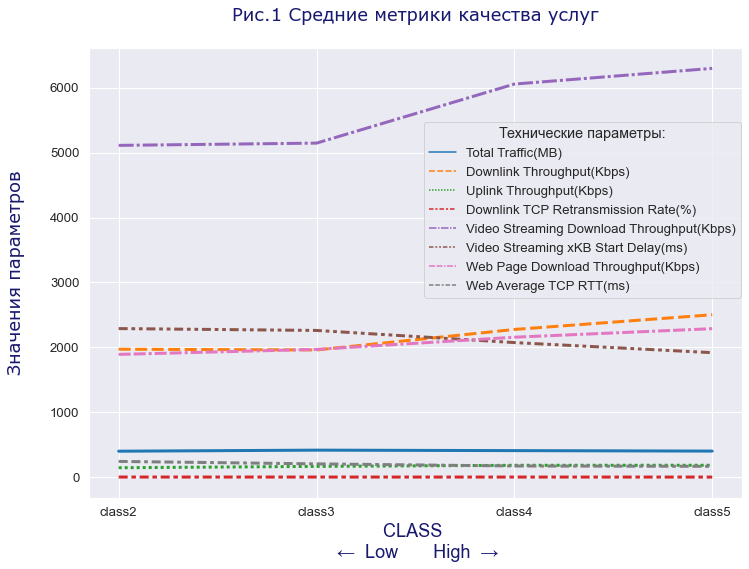

In [11]:
sns.set(rc={'figure.figsize': (11.7, 8.27)}, font_scale=1.2, style='darkgrid')

data = pd.DataFrame(df_mean.drop(['class_rate'], axis=1), df_mean.index)

class_plot = sns.lineplot(data=data, palette='tab10', linewidth=3, alpha=1)

class_plot.set_xlabel('CLASS \n ←  Low       High  →', fontsize=18,
                      fontstyle='normal', color='midnightblue')
class_plot.set_ylabel('Значения параметров\n', fontsize=18, fontfamily='Verdana',
                      fontstyle='normal', color='midnightblue')
class_plot.set_title('Рис.1 Средние метрики качества услуг\n', fontsize=18, fontfamily='Verdana',
                     fontstyle='normal', color='midnightblue')

class_plot.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.legend(bbox_to_anchor=[1.009, 0.64], loc='center right',
           title='Технические параметры:')
plt.show()

##### Анализ графических данных позволяет предположить, что на степень удовлетворенности абонентов благоприятно влияет увеличение параметров Video Streaming Download Throughput(Kbps), и в незначительной степени увеличение Downlink Throughput(Kbps) и Web Page Download Throughput(Kbps). В то же время метрика Video Streaming xKB Start Delay(ms), Downlink TCP Retransmission Rate(%) и Web Average TCP RTT(ms) оказывают негативное влияние на оценки. Остальные метрики не оказывают видимого влияния на рейтинг оценок проведенного опроса.

---

#### Применим методику A/B тестирования, сформулируем статистическую гипотезу для проверки "сигнала" зависимости оценок проведенного опроса от скорости загрузки потокового видео.

Нулевая гипотеза H0:
* рейтинг оценок опроса не зависит от скорости загрузки потокового видео (Video Streaming Download Throughput(Kbps)) , p_slow_stream = p_fast_stream

Альтернативная односторонняя гипотеза H1:
* высокая скорость загрузки потокового видео увеличивает рейтинг оценок опроса, p_slow_stream < p_fast_stream

In [12]:
# Деление датасета по границе средней скорости загрузки потокового видео

df_fast_stream = df[df['Video Streaming Download Throughput(Kbps)']
                    >= df['Video Streaming Download Throughput(Kbps)'].mean()]
df_slow_stream = df[df['Video Streaming Download Throughput(Kbps)']
                    < df['Video Streaming Download Throughput(Kbps)'].mean()]

In [13]:
# Средняя оценка сервиса при высокой скорости загрузки потокового видео

p_fast_stream = df_fast_stream['class_rate'].mean(axis=0)
p_fast_stream

3.8227194492254735

In [14]:
# Средняя оценка сервиса при низкой скорости загрузки потокового видео

p_slow_stream = df_slow_stream['class_rate'].mean(axis=0)
p_slow_stream

3.545128205128205

In [15]:
print('Разница средних оценок в зависимости от скорости потокового видео :',
      p_fast_stream - p_slow_stream)
print('\033[1m' + '\nУ fast_stream средняя оценка выше (косвенный признак преимущества).')

Разница средних оценок в зависимости от скорости потокового видео : 0.2775912440972683

У fast_stream средняя оценка выше (косвенный признак преимущества).


In [19]:
differences = np.zeros((1, 1000))
for i in range(0, 1000):
    s1 = random.choices(df_slow_stream['class_rate'].tolist(), k=1000)
    s2 = random.choices(df_fast_stream['class_rate'].tolist(), k=1000)
    p1 = np.mean(s1)
    p2 = np.mean(s2)
    differences[0][i] = p2 - p1
print('p_value =', (differences >= p_fast_stream - p_slow_stream).sum() / 1000)
p_value = (differences >= p_fast_stream - p_slow_stream).sum() / 1000
if p_value > 0.05:
    print('\033[1m' + '\np_value >= 0.05. Нулевую гипотезу пока НЕ отвергаем!')
else:
    print('\033[1m' + '\np_value < 0.05. Нулевую гипотезу отвергаем!')

p_value = 0.516

p_value >= 0.05. Нулевую гипотезу пока НЕ отвергаем!


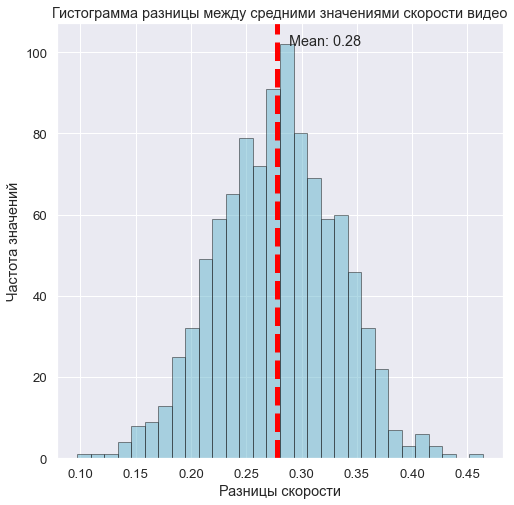

In [20]:
plt.figure(figsize=(8, 8))
plt.hist(differences[0], bins=30, color='c', edgecolor='k', alpha=0.5)
plt.axvline(p_fast_stream - p_slow_stream, color='red',
            linestyle='dashed', linewidth=5)
min_ylim, max_ylim = plt.ylim()
plt.text((p_fast_stream - p_slow_stream)*1.04, max_ylim*0.95,
         'Mean: {:.2f}'.format(p_fast_stream - p_slow_stream))
plt.xlabel('Разницы скорости')
plt.ylabel('Частота значений')
plt.title('Гистограмма разницы между средними значениями скорости видео')
plt.show()

##### пересчет после уточнений

In [21]:
print('p_value =',((differences - np.mean(differences)) >= p_fast_stream - p_slow_stream).sum()/1000)
p_value_new = ((differences - np.mean(differences)) >= p_fast_stream - p_slow_stream).sum()/1000
if p_value_new < 0.05:
    print('\033[1m' + '\np_value < 0.05. Теперь нулевую гипотезу можно отвергнуть!')
else:
    print('\033[1m' + '\np_value >= 0.05. Нулевую гипотезу не отвергаем!')

p_value = 0.0

p_value < 0.05. Теперь нулевую гипотезу можно отвергнуть!


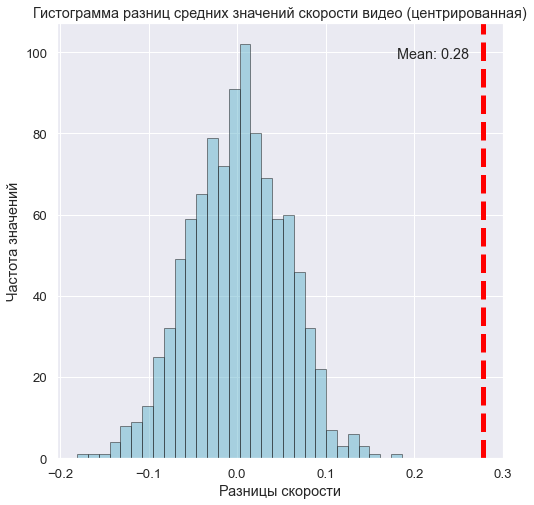

In [22]:
plt.figure(figsize=(8, 8))
plt.hist((differences - np.mean(differences))[0], bins=30, color='c', edgecolor='k', alpha=0.5)
plt.axvline(p_fast_stream - p_slow_stream, color='red', linestyle='dashed', linewidth=5)
plt.text((p_fast_stream - p_slow_stream)*.65, max_ylim*0.92, 'Mean: {:.2f}'.format(p_fast_stream - p_slow_stream))
plt.xlabel('Разницы скорости')
plt.ylabel('Частота значений')
plt.title('Гистограмма разниц средних значений скорости видео (центрированная)')
plt.show()

Вывод: высокие оценки опроса абонентов Q1 напрямую зависят от скорости потокового видео. 
Чем больше скорость, тем выше оценки.

По метрикам Downlink Throughput(Kbps) и Web Page Download Throughput(Kbps) в рамках используемой выше статистической методики получаются такие же значения p_value == 0 ( опускаем однотипные вычисления ! ), что может свидетельствовать в том числе и об их ненулевой взаимной корреляции.

Проверим предположение о взаимной корреляции и рассмотрим указанные метрики более внимательно. Конечная цель - очистка от выбросов + анализ по Чеддоку.

###### Video Streaming Download Throughput(Kbps)


За пределы 3-х сигм выходит: 58 значений.

Базовые метрики
count     3112.000000
mean      5728.806848
std       5161.475235
min          0.000000
25%       2324.550000
50%       4436.500000
75%       7611.440000
max      58566.030000
Name: Video Streaming Download Throughput(Kbps), dtype: float64
------------------------------------
Самые популярные значения метрики, топ 5
6324.73     2
3579.19     2
2135.78     2
12943.06    2
3427.20     1
Name: Video Streaming Download Throughput(Kbps), dtype: int64
------------------------------------
Эксцесс  12.184563628626632
Ассиметрия  2.6118126499425203


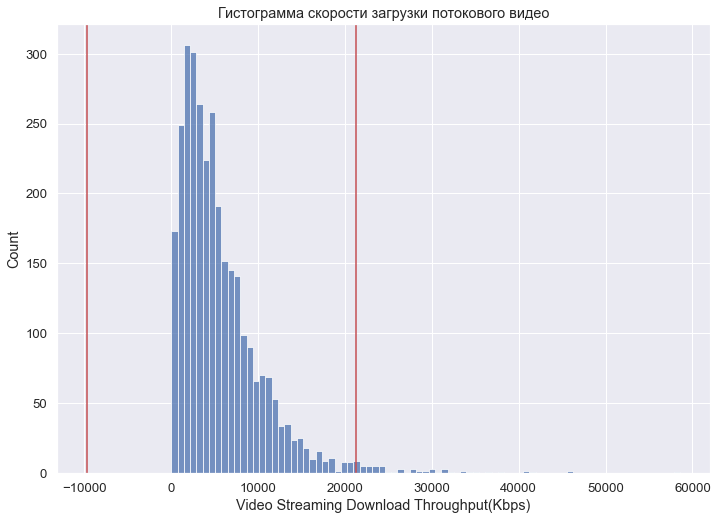

In [23]:
upper_level = df['Video Streaming Download Throughput(Kbps)'].mean()\
    + 3*df['Video Streaming Download Throughput(Kbps)'].std()
lower_level = df['Video Streaming Download Throughput(Kbps)'].mean()\
    - 3*df['Video Streaming Download Throughput(Kbps)'].std()
sns.histplot(df['Video Streaming Download Throughput(Kbps)'])
plt.axvline(x=lower_level, color="r", linestyle="-")
plt.axvline(x=upper_level, color="r", linestyle="-")
plt.title('Гистограмма скорости загрузки потокового видео')
print('\nЗа пределы 3-х сигм выходит:',
      df[(df['Video Streaming Download Throughput(Kbps)'] < lower_level)
         | (df['Video Streaming Download Throughput(Kbps)']
            > upper_level)]['Video Streaming Download Throughput(Kbps)'].count(), 'значений.\n')
print("Базовые метрики")
print(df['Video Streaming Download Throughput(Kbps)'].describe())
print("------------------------------------")

print("Самые популярные значения метрики, топ 5")
print(df['Video Streaming Download Throughput(Kbps)'].value_counts().nlargest(5))
print("------------------------------------")

print("Эксцесс ", kurtosis(df['Video Streaming Download Throughput(Kbps)']))
print("Ассиметрия ", skew(df['Video Streaming Download Throughput(Kbps)']))

In [24]:
# удаление выбросов
df_corr = df[df['Video Streaming Download Throughput(Kbps)'] < upper_level]

###### Downlink Throughput(Kbps)


За пределы 3-х сигм выходит: 53 значений.

Базовые метрики
count     3112.000000
mean      2220.774023
std       2629.824405
min         13.260000
25%        652.297500
50%       1404.230000
75%       2823.645000
max      39817.640000
Name: Downlink Throughput(Kbps), dtype: float64
------------------------------------
Самые популярные значения метрики, топ 5
829.05    2
625.61    2
207.94    2
790.74    2
139.60    2
Name: Downlink Throughput(Kbps), dtype: int64
------------------------------------
Эксцесс  33.33063180411332
Ассиметрия  4.090551714392254


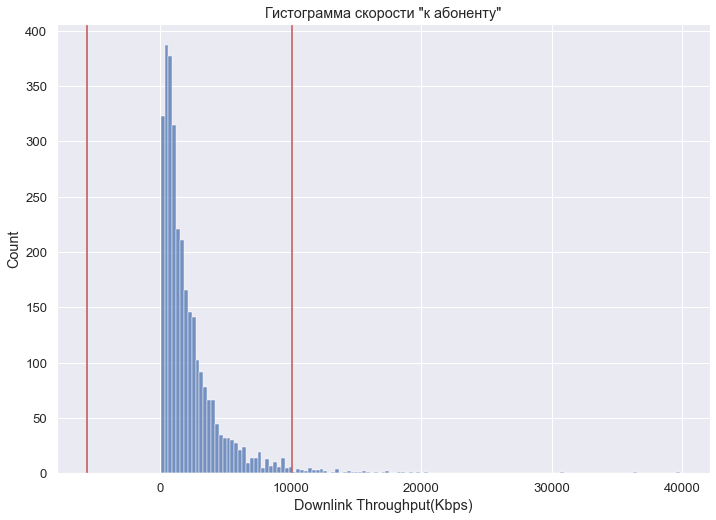

In [25]:
upper_level = df['Downlink Throughput(Kbps)'].mean()\
    + 3*df['Downlink Throughput(Kbps)'].std()
lower_level = df['Downlink Throughput(Kbps)'].mean()\
    - 3*df['Downlink Throughput(Kbps)'].std()
sns.histplot(df['Downlink Throughput(Kbps)'])
plt.axvline(x=lower_level, color="r", linestyle="-")
plt.axvline(x=upper_level, color="r", linestyle="-")
plt.title('Гистограмма скорости "к абоненту"')
print('\nЗа пределы 3-х сигм выходит:',
      df[(df['Downlink Throughput(Kbps)'] < lower_level)
         | (df['Downlink Throughput(Kbps)']
            > upper_level)]['Downlink Throughput(Kbps)'].count(), 'значений.\n')
print("Базовые метрики")
print(df['Downlink Throughput(Kbps)'].describe())
print("------------------------------------")

print("Самые популярные значения метрики, топ 5")
print(df['Downlink Throughput(Kbps)'].value_counts().nlargest(5))
print("------------------------------------")

print("Эксцесс ", kurtosis(df['Downlink Throughput(Kbps)']))
print("Ассиметрия ", skew(df['Downlink Throughput(Kbps)']))

In [26]:
# удаление выбросов
df_corr = df_corr[df_corr['Downlink Throughput(Kbps)'] < upper_level]

###### Web Page Download Throughput(Kbps)


За пределы 3-х сигм выходит: 53 значений.

Базовые метрики
count     3112.000000
mean      2100.258901
std       2062.509549
min          0.000000
25%       1018.002500
50%       1670.695000
75%       2519.987500
max      35603.970000
Name: Web Page Download Throughput(Kbps), dtype: float64
------------------------------------
Самые популярные значения метрики, топ 5
0.00       3
1769.81    2
615.30     2
1639.09    2
2161.87    2
Name: Web Page Download Throughput(Kbps), dtype: int64
------------------------------------
Эксцесс  54.30358838479367
Ассиметрия  5.444421366628787


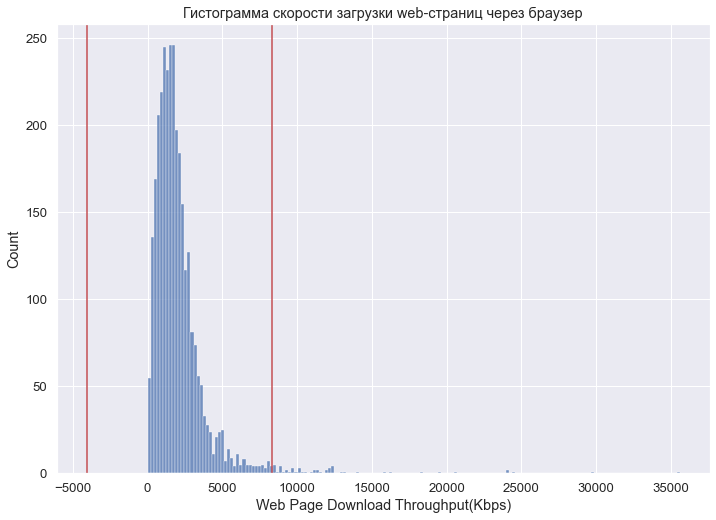

In [27]:
upper_level = df['Web Page Download Throughput(Kbps)'].mean()\
    + 3*df['Web Page Download Throughput(Kbps)'].std()
lower_level = df['Web Page Download Throughput(Kbps)'].mean()\
    - 3*df['Web Page Download Throughput(Kbps)'].std()
sns.histplot(df['Web Page Download Throughput(Kbps)'])
plt.axvline(x=lower_level, color="r", linestyle="-")
plt.axvline(x=upper_level, color="r", linestyle="-")
plt.title('Гистограмма скорости загрузки web-страниц через браузер')
print('\nЗа пределы 3-х сигм выходит:',
      df[(df['Web Page Download Throughput(Kbps)'] < lower_level)
         | (df['Web Page Download Throughput(Kbps)']
            > upper_level)]['Web Page Download Throughput(Kbps)'].count(), 'значений.\n')
print("Базовые метрики")
print(df['Web Page Download Throughput(Kbps)'].describe())
print("------------------------------------")

print("Самые популярные значения метрики, топ 5")
print(df['Web Page Download Throughput(Kbps)'].value_counts().nlargest(5))
print("------------------------------------")

print("Эксцесс ", kurtosis(df['Web Page Download Throughput(Kbps)']))
print("Ассиметрия ", skew(df['Web Page Download Throughput(Kbps)']))

In [28]:
# удаление выбросов
df_corr = df_corr[df_corr['Web Page Download Throughput(Kbps)'] < upper_level]
df_corr = df_corr.loc[df_corr['class'] != 'class1']

##### Матрица парных корреляций для отобранных данных

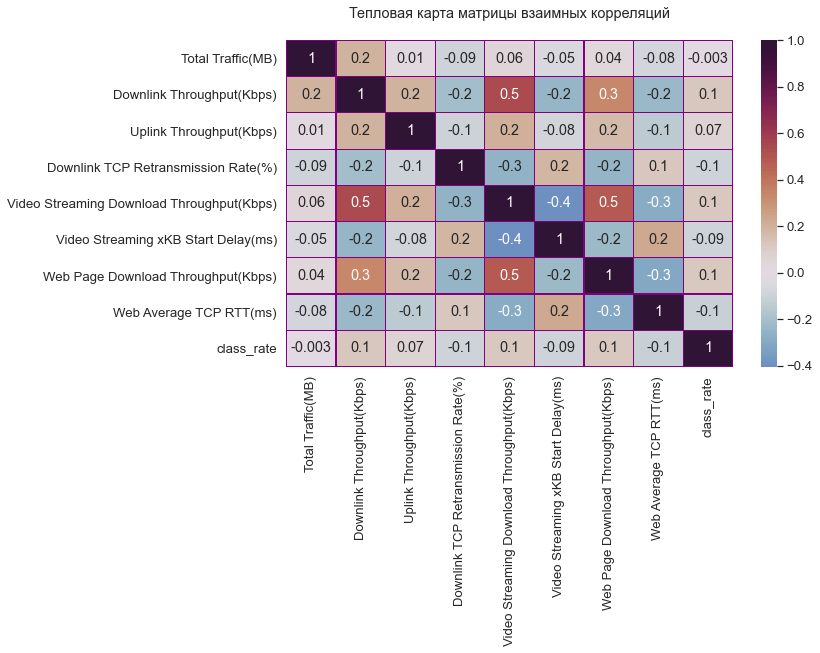

In [29]:
colormap = plt.cm.twilight_shifted
research_list = list(df_corr)
# матрица парных корреляций для отобранных данных
corr_m = df_corr[research_list].corr()
plt.figure(figsize=(10, 6))
plt.title('Тепловая карта матрицы взаимных корреляций\n')
sns.heatmap(corr_m, center=0, cmap=colormap, linewidths=.2,
            linecolor='purple', fmt='.1g', annot=True)
plt.show()

##### Визуализация некоторых корреляций.


Коэффициент корреляции: 0.5


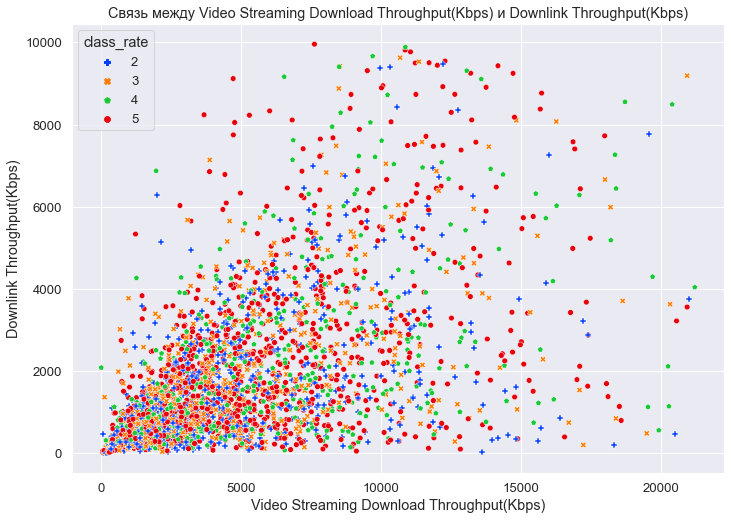


Коэффициент корреляции: -0.4


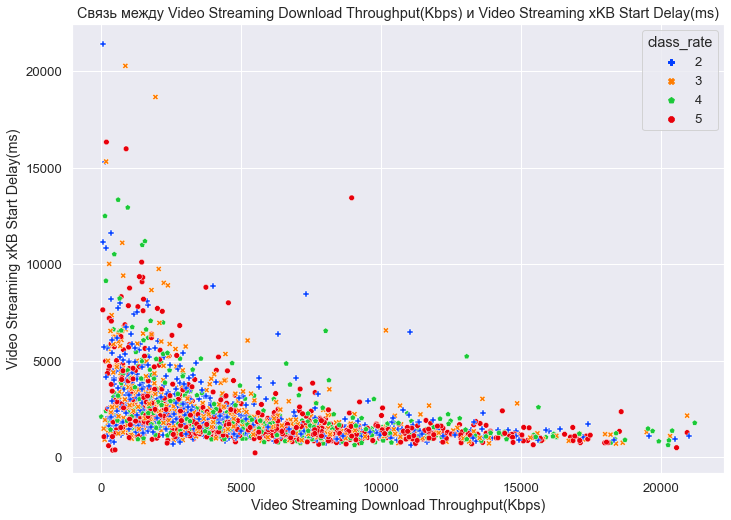


Коэффициент корреляции: 0.5


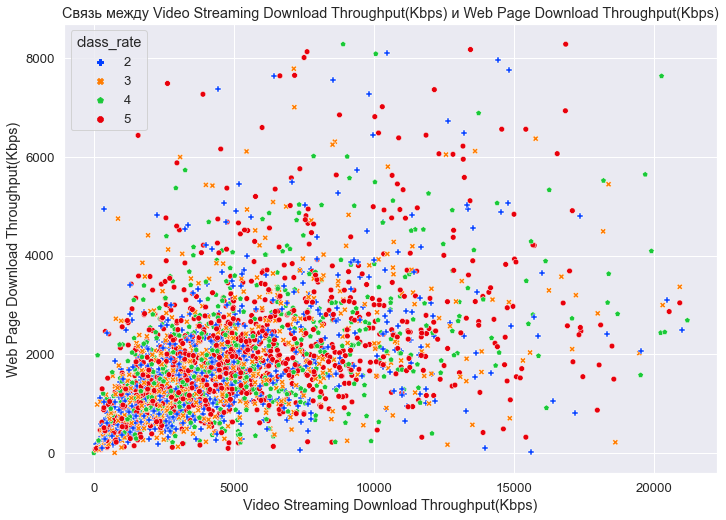

In [30]:
sns.set(rc={'figure.figsize': (11.7, 8.27)}, font_scale=1.2, style='darkgrid')
level = 0.3
markers = {5: '8', 4: 'p', 3: 'X', 2: 'P'}
for i in list(df_corr)[2:-2]:
    curr_corr = df_corr[i].corr(
        df_corr['Video Streaming Download Throughput(Kbps)'])
    if abs(curr_corr) >= level:
        if i != 'Video Streaming Download Throughput(Kbps)':
            sns.scatterplot(
                x='Video Streaming Download Throughput(Kbps)', y=i, data=df_corr,
                hue='class_rate', palette='bright', style='class_rate', markers=markers)
            print('\033[1m' + '\nКоэффициент корреляции: ' +
                  str(round(curr_corr, 1)))
            plt.title(
                'Связь между Video Streaming Download Throughput(Kbps) и ' + str(i))
            plt.show()

Действительно, мы видим ЗАМЕТНЫЕ (>= 0.5) корреляции между скоростью загрузки потокового видео (Video Streaming Download Throughput(Kbps)) с одной стороны и средней скоростью «к абоненту» (Downlink Throughput(Kbps)) и скоростью загрузки web-страниц через браузер (Web Page Download Throughput(Kbps)) с другой стороны.
Что в свою очередь является дополнительным доказательством сделанных статистических выводов о ПОЛОЖИТЕЛЬНОМ влиянии рассматриваемых ТРЁХ метрик на оценки опроса Q1. Дополнительно отметим, что на тепловой карте данные метрики имеют наивысшие значения применительно к усредненным оценкам опроса class_rate.

Параллельно мы выявили умеренную НЕГАТИВНУЮ (-0.4) корреляцию между скоростью загрузки потокового видео (Video Streaming Download Throughput(Kbps)) и задержкой старта воспроизведения видео (Video Streaming xKB Start Delay(ms)), что наблюдалось как отрицательный "сигнал" на Рис.1

# Анализ по Q2

##### Постановка задачи

Проанализируем датасет по той части данных, в которых клиенты "Мегафон" на втором вопросе опроса (Q2) оценивали качество телематических услуг как негативное по причине медленной скорости мобильного интернета и медленной загрузки видео (цифры 4 или 5 в ответе Q2). Это позволит понять возможные направления в изменении целевой сервисной модели для повышения удовлетворенности клиентов.

In [31]:
def Q2_with_45(x):
    if ('4' in str(x)) | ('5' in str(x)):
        return 'Q2_with_45'


df['Q2_with_45'] = df['Q2'].apply(lambda x: Q2_with_45(x))
df_Q2_with_45 = df[df['Q2_with_45'] == 'Q2_with_45']
df_Q2_with_45_mean = df_Q2_with_45.groupby('class').agg('mean')
df_Q2_with_45_mean

,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms),class_rate
class,,,,,,,,,
class2,399.880068,1671.353509,130.243553,2.273421,4100.778070,2636.052632,1668.573465,313.219298,2.0
class3,426.174354,1674.456706,160.118824,2.111647,4225.252471,2473.356863,1837.450235,235.705882,3.0
class4,414.139469,2078.967944,157.798167,1.911389,5347.972667,2146.377778,1985.008222,218.572222,4.0


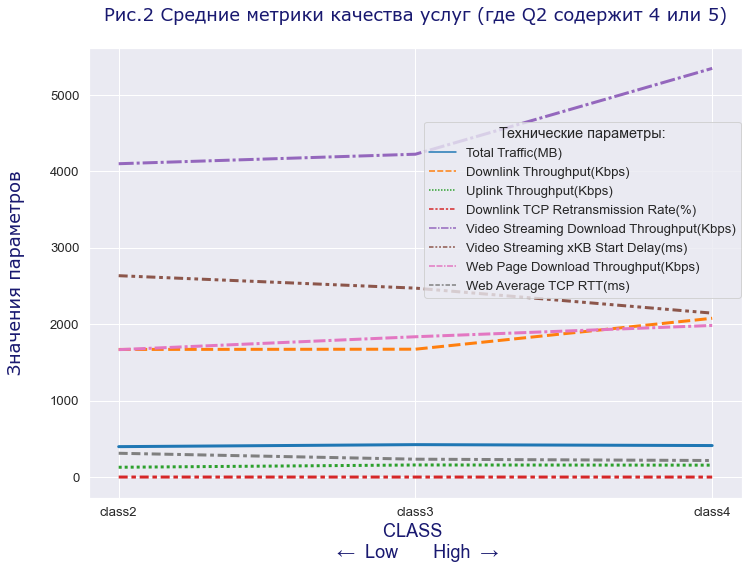

In [32]:
sns.set(rc={'figure.figsize': (11.7, 8.27)}, font_scale=1.2, style='darkgrid')

data = pd.DataFrame(df_Q2_with_45_mean.drop(['class_rate'], axis = 1), df_Q2_with_45_mean.index)

class_plot = sns.lineplot(data=data, palette='tab10', linewidth=3, alpha=1)

class_plot.set_xlabel('CLASS \n ←  Low       High  →', fontsize=18,
                      fontstyle='normal', color='midnightblue')
class_plot.set_ylabel('Значения параметров\n', fontsize=18, fontfamily='Verdana',
                      fontstyle='normal', color='midnightblue')
class_plot.set_title('Рис.2 Средние метрики качества услуг (где Q2 содержит 4 или 5)\n', fontsize=18, fontfamily='Verdana',
                     fontstyle='normal', color='midnightblue')

class_plot.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.legend(bbox_to_anchor=[1.009, 0.64], loc='center right',
           title='Технические параметры:')
plt.show()

###### На Рис.2 наблюдаются схожие зависимости с полученными в Рис.1.

##### Применим методику A/B тестирования, сформулируем статистическую гипотезу для проверки, например, менее очевидного "сигнала" зависимости оценок проведенного опроса от средней скорости «к абоненту» Downlink Throughput(Kbps).

Нулевая гипотеза H0:
* рейтинг оценок опроса не зависит от средней скорости «к абоненту» (Downlink Throughput(Kbps)) , p_slow_downlink = p_fast_downlink

Альтернативная односторонняя гипотеза H1:
* средняя скорость «к абоненту» увеличивает рейтинг оценок опроса, p_slow_downlink < p_fast_downlink

In [33]:
# Деление датасета по границе средней скорости «к абоненту»

df_fast_downlink = df_Q2_with_45[df_Q2_with_45['Downlink Throughput(Kbps)']
                                 >= df_Q2_with_45['Downlink Throughput(Kbps)'].mean()]
df_slow_downlink = df_Q2_with_45[df_Q2_with_45['Downlink Throughput(Kbps)']
                                 < df_Q2_with_45['Downlink Throughput(Kbps)'].mean()]

In [34]:
# Средняя оценка сервиса при высокой скорости «к абоненту»

p_fast_downlink = df_fast_downlink['class_rate'].mean(axis=0)
p_fast_downlink

3.037037037037037

In [35]:
# Средняя оценка сервиса при низкой скорости «к абоненту»

p_slow_downlink = df_slow_downlink['class_rate'].mean(axis=0)
p_slow_downlink

2.8747203579418343

In [36]:
print('Разница средних оценок в зависимости от скорости «к абоненту» :',
      p_fast_downlink - p_slow_downlink)
print('\033[1m' + '\nУ fast_downlink средняя оценка выше (косвенный признак преимущества).')

Разница средних оценок в зависимости от скорости «к абоненту» : 0.16231667909520286

У fast_downlink средняя оценка выше (косвенный признак преимущества).


In [37]:
differences = np.zeros((1, 1000))
for i in range(0, 1000):
    s1 = random.choices(df_slow_downlink['class_rate'].tolist(), k=1000)
    s2 = random.choices(df_fast_downlink['class_rate'].tolist(), k=1000)
    p1 = np.mean(s1)
    p2 = np.mean(s2)
    differences[0][i] = p2 - p1
print('p_value =', (differences >= p_fast_downlink - p_slow_downlink).sum() / 1000)
p_value = (differences >= p_fast_downlink - p_slow_downlink).sum() / 1000
if p_value > 0.05:
    print('\033[1m' + '\np_value >= 0.05. Нулевую гипотезу пока НЕ отвергаем!')
else:
    print('\033[1m' + '\np_value < 0.05. Нулевую гипотезу отвергаем!')

p_value = 0.492

p_value >= 0.05. Нулевую гипотезу пока НЕ отвергаем!


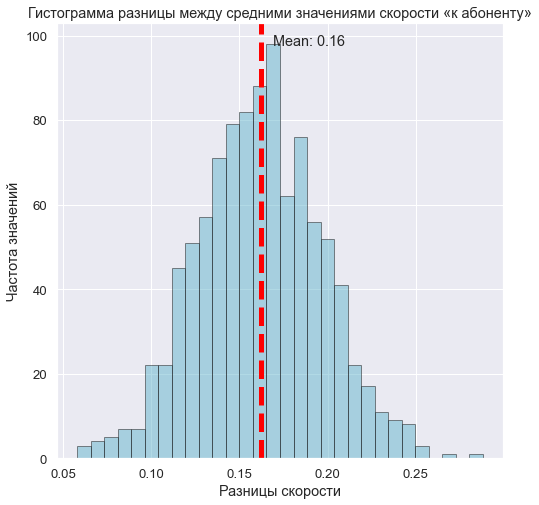

In [38]:
plt.figure(figsize=(8, 8))
plt.hist(differences[0], bins=30, color='c', edgecolor='k', alpha=0.5)
plt.axvline(p_fast_downlink - p_slow_downlink, color='red',
            linestyle='dashed', linewidth=5)
min_ylim, max_ylim = plt.ylim()
plt.text((p_fast_downlink - p_slow_downlink)*1.04, max_ylim*0.95,
         'Mean: {:.2f}'.format(p_fast_downlink - p_slow_downlink))
plt.xlabel('Разницы скорости')
plt.ylabel('Частота значений')
plt.title('Гистограмма разницы между средними значениями скорости «к абоненту»')
plt.show()

###### пересчет после уточнений

In [39]:
print('p_value =',((differences - np.mean(differences)) >= p_fast_downlink - p_slow_downlink).sum()/1000)
p_value_new = ((differences - np.mean(differences)) >= p_fast_downlink - p_slow_downlink).sum()/1000
if p_value_new < 0.05:
    print('\033[1m' + '\np_value < 0.05. Теперь нулевую гипотезу можно отвергнуть!')
else:
    print('\033[1m' + '\np_value >= 0.05. Нулевую гипотезу не отвергаем!')

p_value = 0.0

p_value < 0.05. Теперь нулевую гипотезу можно отвергнуть!


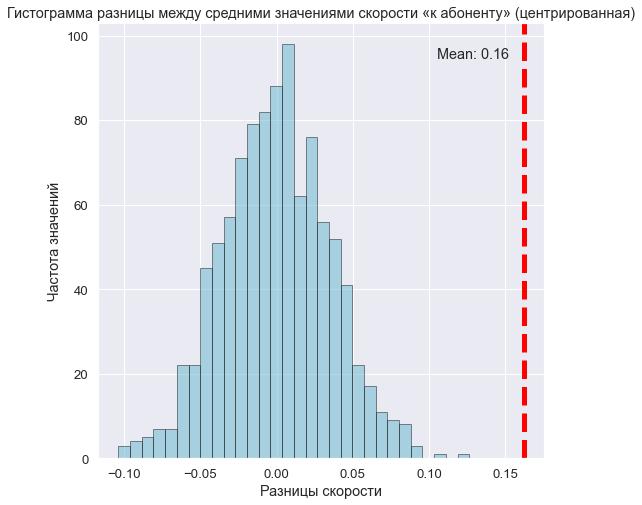

In [40]:
plt.figure(figsize=(8, 8))
plt.hist((differences - np.mean(differences))[0], bins=30, color='c', edgecolor='k', alpha=0.5)
plt.axvline(p_fast_downlink - p_slow_downlink, color='red', linestyle='dashed', linewidth=5)
plt.text((p_fast_downlink - p_slow_downlink)*.65, max_ylim*0.92, 'Mean: {:.2f}'.format(p_fast_downlink - p_slow_downlink))
plt.xlabel('Разницы скорости')
plt.ylabel('Частота значений')
plt.title('Гистограмма разницы между средними значениями скорости «к абоненту» (центрированная)')
plt.show()

#### Вывод: высокая скорость «к абоненту» характерна для  более позитивного уровня оценок в группе абонентов, считающих во втором опросе Q2 скорость мобильного интернета и скорость загрузки видео медленной.

#### Аналогичные результаты будут получены и по метрикам Video Streaming Download Throughput(Kbps) и Web Page Download Throughput(Kbps), p_value == 0 ( опускаем однотипные вычисления  ).

# Анализ по Q1 и Q2

#### Постановка задачи. Узнаем верно ли, что для групп с положительными и отрицательными оценками значения величины рассматриваемых метрик статистически достоверно различаются? На сколько?

##### Определим абонентов, указавшиx 1 и более критериев негативной оценки качества телематических услуг в вопросе Q2.

In [41]:
df_q2 = df.dropna(subset=['Q2']).copy()
df_q2['negative_count'] = df_q2['Q2'].str.count('\d+')
df_q2 = df_q2[df_q2['negative_count'] >= 1]
print('Количество абонентов с 1 и более негативной оценкой в опросе Q2 =',
      df_q2.shape[0])
print('При этом, максимальное количество негативных оценок составило',
      df_q2['negative_count'].max(), 'шт, которые были получены от',
      df_q2[df_q2['negative_count'] == df_q2['negative_count'].max()].shape[0],
      'абонентов.')
print('Количество абонентов, поставивших положительные оценки, составило',
      df[df['class_rate'] == 5].shape[0])

Количество абонентов с 1 и более негативной оценкой в опросе Q2 = 1315
При этом, максимальное количество негативных оценок составило 6 шт, которые были получены от 2 абонентов.
Количество абонентов, поставивших положительные оценки, составило 1087


Проведем разведочный анализ.

* Video Streaming Download Throughput(Kbps)

In [42]:
p_pozitive_mean = df[df['class_rate'] == 5]['Video Streaming Download Throughput(Kbps)'].mean()
p_negative_mean = df_q2['Video Streaming Download Throughput(Kbps)'].mean()
print('Разница средних значений :', p_pozitive_mean - p_negative_mean)
print('Относительная величина разницы значений от общего среднего :',
      round((p_pozitive_mean - p_negative_mean) / df['Video Streaming Download Throughput(Kbps)'].mean()*100, 2), end=' %')

Разница средних значений : 866.9886833472574
Относительная величина разницы значений от общего среднего : 15.13 %

* Downlink Throughput(Kbps)

In [43]:
p_pozitive_mean = df[df['class_rate'] == 5]['Downlink Throughput(Kbps)'].mean()
p_negative_mean = df_q2['Downlink Throughput(Kbps)'].mean()
print('Разница средних значений :', p_pozitive_mean - p_negative_mean)
print('Относительная величина разницы значений от общего среднего :',
      round((p_pozitive_mean - p_negative_mean) / df['Downlink Throughput(Kbps)'].mean()*100, 2), end=' %')

Разница средних значений : 438.26729348225217
Относительная величина разницы значений от общего среднего : 19.73 %

* Web Page Download Throughput(Kbps)

In [44]:
p_pozitive_mean = df[df['class_rate'] == 5]['Web Page Download Throughput(Kbps)'].mean()
p_negative_mean = df_q2['Web Page Download Throughput(Kbps)'].mean()
print('Разница средних значений :', p_pozitive_mean - p_negative_mean)
print('Относительная величина разницы значений от общего среднего :',
      round((p_pozitive_mean - p_negative_mean) / df['Web Page Download Throughput(Kbps)'].mean()*100, 2), end=' %')

Разница средних значений : 261.86459014064985
Относительная величина разницы значений от общего среднего : 12.47 %

###### Обобщим относительные разницы средних значений всех метрик и представим в графическом виде.

In [45]:
df1 = df_q2.describe()[1:2].drop(['class_rate', 'negative_count'], axis=1).T
df1.columns = ['mean_negative']
df2 = df[df['class_rate'] == 5].describe()[1:2].drop(['class_rate'], axis=1).T
df2.columns = ['mean_positive']
df3 = df.describe()[1:2].drop(['class_rate'], axis=1).T
df3.columns = ['mean_all']
df4 = df1.merge(df2, left_index=True, right_index=True).merge(
    df3, left_index=True, right_index=True)
df4['rez'] = (df4['mean_positive'] - df4['mean_negative'])/df4['mean_all']*100
df4

,mean_negative,mean_positive,mean_all,rez
Total Traffic(MB),408.351231,401.776742,406.282339,-1.618207
Downlink Throughput(Kbps),2063.932228,2502.199522,2220.774023,19.734889
Uplink Throughput(Kbps),162.448517,183.535106,170.702381,12.352838
Downlink TCP Retransmission Rate(%),1.928639,1.651104,1.834518,-15.128488
Video Streaming Download Throughput(Kbps),5430.857977,6297.846661,5728.806848,15.133844
Video Streaming xKB Start Delay(ms),2277.691255,1918.253910,2107.596080,-17.054375
Web Page Download Throughput(Kbps),2025.908243,2287.772833,2100.258901,12.468205
Web Average TCP RTT(ms),216.967300,167.265869,194.195051,-25.593562


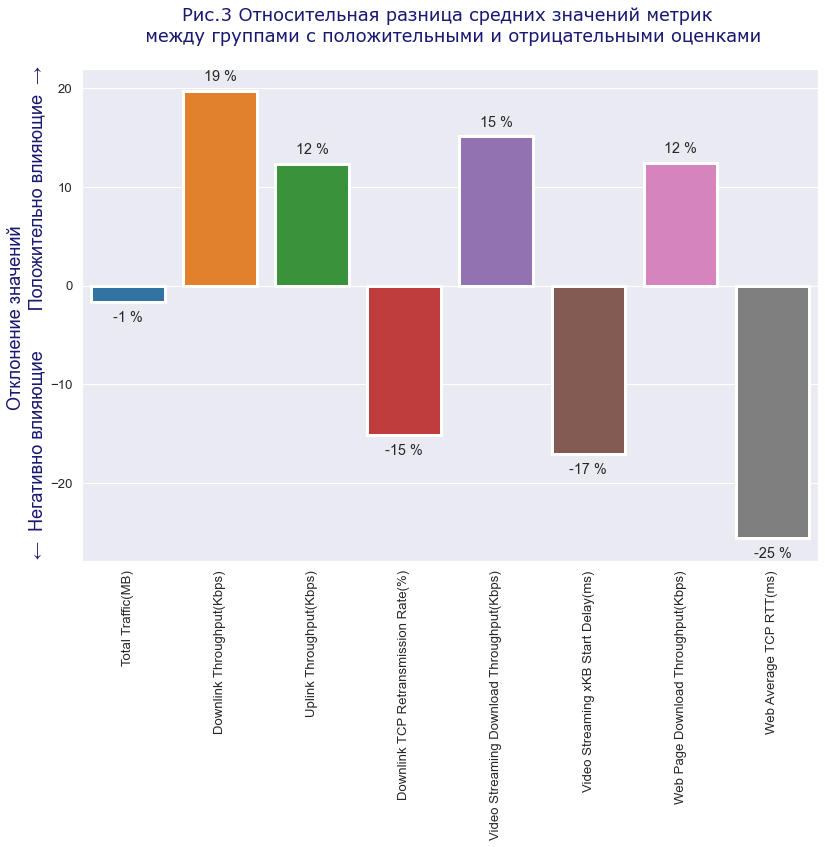

In [46]:
sns.set(rc={'figure.figsize': (11.7, 12)}, font_scale=1.2, style='darkgrid')

class_plot = sns.barplot(x=df4.index, y="rez", data=df4,
                         palette='tab10', linewidth=3, alpha=1)

class_plot.set_ylabel('Отклонение значений \n ←  Негативно влияющие        Положительно влияющие  →', fontsize=18,
                      fontstyle='normal', color='midnightblue')

class_plot.set_title('Рис.3 Относительная разница средних значений метрик \n между группами с положительными и отрицательными оценками\n', fontsize=18, fontfamily='Verdana',
                     fontstyle='normal', color='midnightblue')
plt.xticks(rotation=90)
plt.tight_layout()


def show_values_on_bars(axs, h_v='v', space=0.4):
    def _show_on_single_plot(ax):
        if h_v == 'v':
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                if p.get_height() >= 0:
                    _y = p.get_y() + p.get_height() + 1
                else:
                    _y = p.get_y() + p.get_height() - 2
                value = int(p.get_height())
                ax.text(_x, _y, str(value)+' %', ha='center')
        elif h_v == 'h':
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha='left')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


show_values_on_bars(class_plot, 'v')

Рис.3 демонстрирует отклонения средних значений продуктовых метрик от средних базовых в группах с положительными и неположительными оценками опроса. В группе положительных отметок метрики Downlink Throughput(Kbps), Uplink Throughput(Kbps), Video Streaming Download Throughput(Kbps), Web Page Download Throughput(Kbps) являются положительными значениями, а метрики Downlink TCP Retransmission Rate(%), Video Streaming xKB Start Delay(ms), Web Average TCP RTT(ms) являются отрицательными значениями. Средними отклонениями Total Traffic(MB) можно пренебречь в силу их групповой схожести (ниже будет приведено обоснования принятие нулевой гипотезы H0). При этом, как было установлено ранее, только следующие метрики оказывают позитивное влияние на уровень положительных оценок: Video Streaming Download Throughput(Kbps), Downlink Throughput(Kbps) и Web Page Download Throughput(Kbps). В свою очередь негативное воздействие на оценки оказывают метрики: Video Streaming xKB Start Delay(ms), Web Average TCP RTT(ms) и Downlink TCP Retransmission Rate(%).

##### Проверим нулевые и альтернативные гипотезы о  различии средних значений количественных переменных в случае, когда имеются две сравниваемые группы с положительными и отрицательными оценками с помощью t-критерия Стьюдента.

Нулевая гипотеза H0 – средние двух выборок равны, альтернативная гипотеза H1 – средние двух выборок не равны. Проведем тестирование:

t-тест Стьюдента чувствителен к "нормальности" распределения данных. Но наши данные могут не соответствовать этому правилу, поэтому воспользуемся предварительной проверкой по критерию Манна-Уитни, также известному как Критерий Уилкоксона.

In [48]:
m='-'
for metrics in list(df)[2:10]:
    u, p_value = st.mannwhitneyu(df_q2[metrics], df[df['class_rate'] == 5][metrics])
    print(metrics)
    print('two-sample wilcoxon-test :', p_value)
    print(100*m)

Total Traffic(MB)
two-sample wilcoxon-test : 0.20478360292854392
----------------------------------------------------------------------------------------------------
Downlink Throughput(Kbps)
two-sample wilcoxon-test : 4.876212684869284e-07
----------------------------------------------------------------------------------------------------
Uplink Throughput(Kbps)
two-sample wilcoxon-test : 0.010554068944695542
----------------------------------------------------------------------------------------------------
Downlink TCP Retransmission Rate(%)
two-sample wilcoxon-test : 3.957162872173307e-06
----------------------------------------------------------------------------------------------------
Video Streaming Download Throughput(Kbps)
two-sample wilcoxon-test : 5.112368772066037e-09
----------------------------------------------------------------------------------------------------
Video Streaming xKB Start Delay(ms)
two-sample wilcoxon-test : 1.35691487621349e-11
-----------------------

Видно, что p_value по Уилкоксону везде, кроме первой метрики < 0.05, что уже позволяет нам принять H1 гипотезу по всем метрикам, кроме Total Traffic(MB). Однако, проведем t-test Стьюдента...

In [49]:
alpha = 0.05
for metrics in list(df)[2:10]:
    pvalue = scipy.stats.ttest_ind(df_q2[metrics],
                                   df[df['class_rate'] == 5][metrics])[1]
    if pvalue > alpha:
        print(metrics, ': принимаем нулевую гипотезу H0 (метрики НЕ различаются), p_value=', round(
            pvalue, 2), '\n')
    else:
        print(metrics, ': принимаем гипотезу H1 (метрики статистически различны), p_value=', round(
            pvalue, 2), '\n')

Total Traffic(MB) : принимаем нулевую гипотезу H0 (метрики НЕ различаются), p_value= 0.47 

Downlink Throughput(Kbps) : принимаем гипотезу H1 (метрики статистически различны), p_value= 0.0 

Uplink Throughput(Kbps) : принимаем гипотезу H1 (метрики статистически различны), p_value= 0.01 

Downlink TCP Retransmission Rate(%) : принимаем гипотезу H1 (метрики статистически различны), p_value= 0.0 

Video Streaming Download Throughput(Kbps) : принимаем гипотезу H1 (метрики статистически различны), p_value= 0.0 

Video Streaming xKB Start Delay(ms) : принимаем гипотезу H1 (метрики статистически различны), p_value= 0.0 

Web Page Download Throughput(Kbps) : принимаем гипотезу H1 (метрики статистически различны), p_value= 0.0 

Web Average TCP RTT(ms) : принимаем гипотезу H1 (метрики статистически различны), p_value= 0.0 



##### Дополнительно исследуем доверительные интервалы продуктовых метрик по группам абонентов с положительными и отрицательными оценками.

In [60]:
x = ' '
m = '-'
print(30*x, '\033[1m' + 'Доверительные интервалы :\n'+'\033[0m')
print(100*m)
print(100*m)
for metrics in list(df)[2:10]:
    a = stm.DescrStatsW(df[df['class_rate'] == 5][metrics]).tconfint_mean()
    b = stm.DescrStatsW(df_q2[metrics]).tconfint_mean()
    print(metrics, '( оценка + ), интервал:',
          round(a[0], 2), '-', round(a[1], 2))
    print(metrics, '( оценка - ), интервал:',
          round(b[0], 2), '-', round(b[1], 2))
    a3 = max(a[0], b[0])
    b3 = min(a[1], b[1])
    if a3 < b3:
        print(10*x, '\033[1m' + 'Диапазон пересечения интервалов:' +
              '\033[0m', round(a3, 2), '-', round(b3, 2))
    elif a3 == b3:
        print(a3, '\n')
    else:
        print(10*x, '\033[1m' + 'Интервалы не пересекаются.' + '\033[0m')
    print(100*m)
    print(100*m)

                               Доверительные интервалы :

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Total Traffic(MB) ( оценка + ), интервал: 388.57 - 414.98
Total Traffic(MB) ( оценка - ), интервал: 396.43 - 420.27
           Диапазон пересечения интервалов: 396.43 - 414.98
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Downlink Throughput(Kbps) ( оценка + ), интервал: 2339.23 - 2665.17
Downlink Throughput(Kbps) ( оценка - ), интервал: 1929.96 - 2197.91
           Интервалы не пересекаются.
----------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------

Наблюдение. Пересечение доверительных интервалов метрики Uplink Throughput(Kbps) незначительное, что также подтверждается ранее полученной p_value= 0.01.

#### Выводы: практически все рассмотренные метрики качества телекоммуникационных услуг (за исключением Total Traffic(MB)) статистически достоверно различаются. Что говорит об их реальном влиянии на проставленные оценки в опросе.

### Общие выводы по всем исследованиям. Улучшая технические показатели метрик Downlink Throughput(Kbps), Video Streaming Download Throughput(Kbps), Web Page Download Throughput(Kbps) в сторону увеличения их параметров, а также Downlink TCP Retransmission Rate(%), Video Streaming xKB Start Delay(ms), Web Average TCP RTT(ms) в сторону уменьшения их параметров компания "Мегафон" вправе рассчитывать на увеличение общей удовлетворенности абонентов, что, как правило, влечет за собой увеличение маржинальности бизнеса.